In [ ]:
!pip install quandl

In [ ]:
pip install fredapi

In [ ]:

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import ggplot, aes, geom_line, labs, theme_light
import datetime as dt
import quandl
from fredapi import Fred
import warnings
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error



from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from datetime import timedelta

# Suppress FutureWarnings from yfinance
warnings.simplefilter(action='ignore', category=FutureWarning)


Please enter the ticker symbol you want to analyze: BLK


[*********************100%%**********************]  8 of 8 completed


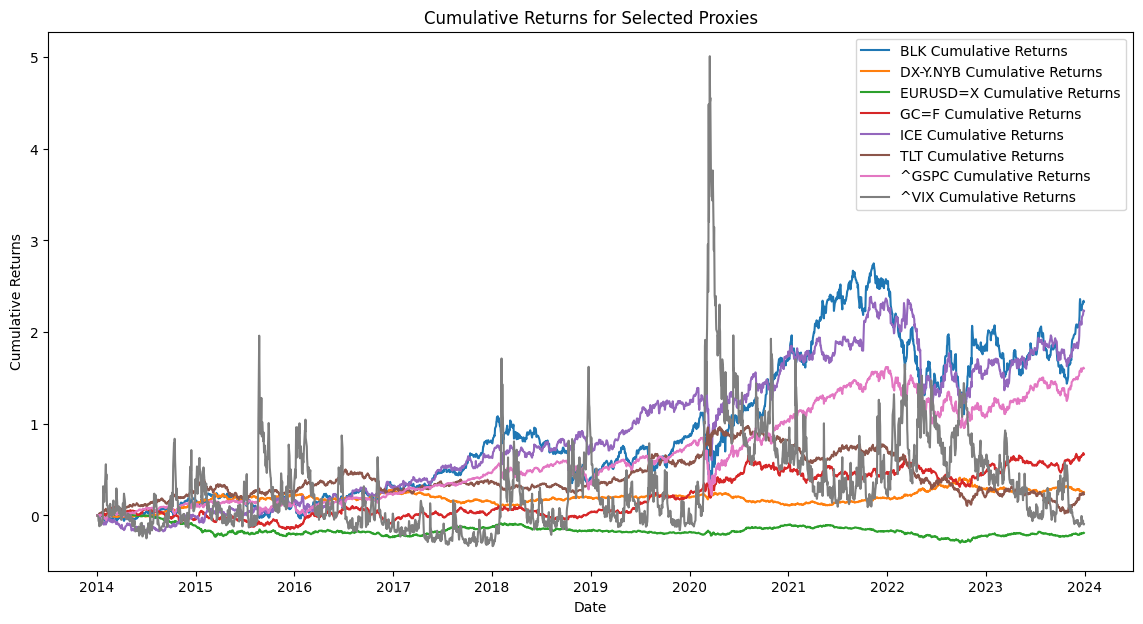

Ticker           BLK  DX-Y.NYB  EURUSD=X      GC=F       ICE       TLT  \
Date                                                                     
2023-12-22  2.292319  0.258819 -0.194666  0.661095  2.165575  0.226437   
2023-12-26  2.309511  0.255972 -0.193637  0.661983  2.188992  0.229924   
2023-12-27  2.336755  0.250031 -0.191972  0.681121  2.217697  0.251718   
2023-12-28  2.341514  0.253002 -0.187170  0.674661  2.238093  0.242627   
2023-12-29  2.330805  0.254239 -0.190129  0.665375  2.233812  0.231419   

Ticker         ^GSPC      ^VIX  
Date                            
2023-12-22  1.596215 -0.053052  
2023-12-26  1.607201 -0.055959  
2023-12-27  1.610931 -0.096657  
2023-12-28  1.611897 -0.093750  
2023-12-29  1.604515 -0.095204  
Cumulative returns data saved successfully to 'cumulative_returns_data.csv'.


In [ ]:
# Dates for data fetching
end_date = "2024-01-01"
start_date = (dt.datetime.strptime(end_date, "%Y-%m-%d") - dt.timedelta(days=10*365)).strftime('%Y-%m-%d')

def download_data(tickers, start_date, end_date):
    """Download historical data for given tickers from start_date to end_date, dropping non-trading days."""
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    data.dropna(inplace=True)
    return data

def plot_cumulative_returns(data):
    """Plot cumulative returns directly from adjusted close prices."""
    cumulative_returns = data / data.iloc[0] - 1
    plt.figure(figsize=(14, 7))
    for col in cumulative_returns.columns:
        plt.plot(cumulative_returns.index, cumulative_returns[col], label=f'{col} Cumulative Returns')
    plt.title('Cumulative Returns for Selected Proxies')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.show()
    return cumulative_returns

# Request user input for the ticker
user_ticker = input("Please enter the ticker symbol you want to analyze: ")

# Define default tickers and add the user's choice
tickers = ['^GSPC', '^VIX', 'TLT', 'GC=F', 'EURUSD=X', 'DX-Y.NYB', 'ICE']  # Default tickers
if user_ticker not in tickers:
    tickers.append(user_ticker)  # Add the user's ticker if not already included

# Download the data using the correct start and end dates
index_data = download_data(tickers, start_date, end_date)

# Plot the cumulative returns and capture the data
cumulative_returns_data = plot_cumulative_returns(index_data)

# Save the cumulative returns to a CSV file
cumulative_returns_data.to_csv('cumulative_returns_data.csv', index=True)

# Output the last few rows and a confirmation message
print(cumulative_returns_data.tail())
print("Cumulative returns data saved successfully to 'cumulative_returns_data.csv'.")

## Daily Returns of ICE U.S. Dollar Index, Euro-USD Exchange Rate, Gold Currency, ICE, US Treasury Bonds, S&P 500, and VIX Index

In [ ]:
def calculate_daily_returns(data):
    """Calculate daily returns."""
    daily_returns = data.pct_change()
    daily_returns = daily_returns.fillna(0)  # Fill initial NaN with 0 (first day return)
    return daily_returns

# Download data with updated tickers
index_data = download_data(tickers, start_date, end_date)

# Calculate daily returns for the updated data
daily_returns = calculate_daily_returns(index_data)

# Dynamic column renaming based on tickers included
ticker_names = {
    '^GSPC': 'S&P 500',
    '^VIX': 'VIX Index',
    'TLT': 'US Treasury Bonds',
    'GC=F': 'Gold Currency',
    'EURUSD=X': 'Euro-USD Exchange Rate',
    'DX-Y.NYB': 'ICE U.S. Dollar Index',
    'ICE': 'ICE',
    user_ticker: user_ticker  # Add a descriptive suffix for the user's ticker
}

# Rename the columns dynamically
daily_returns.columns = [ticker_names.get(x, x) for x in daily_returns.columns]

# Print the daily returns to verify
print(daily_returns.tail(10))  # Display the last 10 rows


[*********************100%%**********************]  8 of 8 completed


                 BLK  ICE U.S. Dollar Index  Euro-USD Exchange Rate  \
Date                                                                  
2023-12-15  0.014706               0.005787                0.009872   
2023-12-18 -0.027546              -0.000390               -0.008945   
2023-12-19  0.006203              -0.003317                0.002622   
2023-12-20 -0.015161               0.002349                0.005238   
2023-12-21  0.012506              -0.005566               -0.003218   
2023-12-22  0.004155              -0.001375                0.005525   
2023-12-26  0.005222              -0.002262                0.001278   
2023-12-27  0.008232              -0.004730                0.002065   
2023-12-28  0.001426               0.002377                0.005943   
2023-12-29 -0.003205               0.000988               -0.003641   

            Gold Currency       ICE  US Treasury Bonds   S&P 500  VIX Index  
Date                                                                 

## APIs for Federal Funds Rate & Treasury Yields



In [ ]:
# Quandl and FRED setup, check README for links to API sites
quandl.ApiConfig.api_key = 'create and put your own API key'
fred = Fred(api_key='create and put your own API key')

# Fetch U.S. Treasury Yields from Quandl
treasury_yields = quandl.get("USTREASURY/YIELD", start_date=start_date, end_date=end_date)
print(f"U.S. Treasury Yields from {start_date} to {end_date}:")
print(treasury_yields['10 YR'])

# Calculate daily returns for Treasury Yields
treasury_yields_daily_returns = calculate_daily_returns(treasury_yields['10 YR'])
#print("Daily Returns for 10 YR Treasury Yields:")
#print(treasury_yields_daily_returns)

# Fetch Federal Funds Effective Rate daily from FRED
ff_rate_daily = fred.get_series('DFF', observation_start=start_date, observation_end=end_date)
#print(f"Federal Funds Effective Rate Daily from {start_date} to {end_date}:")
#print(ff_rate_daily)

# Calculate daily returns for Federal Funds Rate
ff_rate_daily_returns = calculate_daily_returns(ff_rate_daily)
print("Daily Returns for Federal Funds Rate:")
print(ff_rate_daily_returns)


U.S. Treasury Yields from 2014-01-03 to 2024-01-01:
Date
2014-01-03    3.01
2014-01-06    2.98
2014-01-07    2.96
2014-01-08    3.01
2014-01-09    2.97
              ... 
2023-12-22    3.90
2023-12-26    3.89
2023-12-27    3.79
2023-12-28    3.84
2023-12-29    3.88
Name: 10 YR, Length: 2501, dtype: float64
Daily Returns for Federal Funds Rate:
2014-01-03    0.000
2014-01-04    0.000
2014-01-05    0.000
2014-01-06    0.000
2014-01-07   -0.125
              ...  
2023-12-28    0.000
2023-12-29    0.000
2023-12-30    0.000
2023-12-31    0.000
2024-01-01    0.000
Length: 3651, dtype: float64


## Combine interest rates & index data

In [ ]:
# Define dates for data fetching
start_date = "2014-01-01"
end_date = "2024-01-01"

# Download data from Yahoo Finance
index_data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Calculate daily returns
daily_returns = calculate_daily_returns(index_data)

# Dynamic column renaming based on tickers included
ticker_names = {
    '^GSPC': 'S&P 500',
    '^VIX': 'VIX Index',
    'TLT': 'US Treasury Bonds',
    'GC=F': 'Gold Currency',
    'EURUSD=X': 'Euro-USD Exchange Rate',
    'DX-Y.NYB': 'ICE U.S. Dollar Index',
    'ICE': 'ICE',
    user_ticker: user_ticker  # Add a descriptive suffix for the user's ticker
}

# Rename the columns dynamically
daily_returns.columns = [ticker_names.get(x, x + ' Returns') for x in daily_returns.columns]

# Quandl and FRED setup
quandl.ApiConfig.api_key = 'Mxzgjzo1Kjiyf1pyyfRh'
fred = Fred(api_key='34a773bd59dd3c3a1603622a42ff7944')
# Fetch data from Quandl and FRED
treasury_yields = quandl.get("USTREASURY/YIELD", start_date=start_date, end_date=end_date)['10 YR']
ff_rate_daily = fred.get_series('DFF', observation_start=start_date, observation_end=end_date)

# Convert series to DataFrame
treasury_yields = treasury_yields.to_frame("10 YR Treasury Yields")
ff_rate_daily = ff_rate_daily.to_frame("Federal Funds Rate")

# Align and combine all data frames by date
combined_data = pd.concat([daily_returns, treasury_yields, ff_rate_daily], axis=1)

# Fill any missing values that might result from mismatched dates (weekends, holidays, etc.)
combined_data = combined_data.fillna(method='ffill').fillna(method='bfill')

# Remove the last two rows of the dataset
combined_data = combined_data.iloc[:-2]  # Ensure to remove only two rows (last line had "-3")

# Print the combined data to verify the last few rows after removal
print(combined_data.tail())  # Display the last few rows to verify that the last two have been removed

# Save the modified combined data to a CSV file
combined_data.to_csv('combined_financial_data.csv', index=True)


[*********************100%%**********************]  8 of 8 completed


                 BLK  ICE U.S. Dollar Index  Euro-USD Exchange Rate  \
2023-12-26  0.005222              -0.002262               -0.000573   
2023-12-27  0.008232              -0.004730                0.002065   
2023-12-28  0.001426               0.002377                0.005943   
2023-12-29 -0.003205               0.000988               -0.003641   
2023-12-30 -0.003205               0.000988               -0.003641   

            Gold Currency       ICE  US Treasury Bonds   S&P 500  VIX Index  \
2023-12-26       0.000535  0.007397           0.002843  0.004232  -0.003070   
2023-12-27       0.011515  0.009001           0.017720  0.001430  -0.043110   
2023-12-28      -0.003843  0.006339          -0.007263  0.000370   0.003218   
2023-12-29      -0.005545 -0.001322          -0.009020 -0.002826  -0.001604   
2023-12-30      -0.005545 -0.001322          -0.009020 -0.002826  -0.001604   

            10 YR Treasury Yields  Federal Funds Rate  
2023-12-26                   3.89         

## Save Indexes + Rates as a Dataset, then combine it with Sentiment

In [ ]:

# Load the new dataset to inspect its structure
data = '/content/combined_financial_data.csv'
combined_financial_data = pd.read_csv(data)

# Display the first few rows of the combined financial data
combined_financial_data.head()


,Unnamed: 0,BLK,ICE U.S. Dollar Index,Euro-USD Exchange Rate,Gold Currency,ICE,US Treasury Bonds,S&P 500,VIX Index,10 YR Treasury Yields,Federal Funds Rate
0,2014-01-01,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,3.00,0.07
1,2014-01-02,0.00000,0.000000,0.001583,0.000000,0.000000,0.0,0.000000,0.000000,3.00,0.08
2,2014-01-03,0.00438,0.001984,-0.007271,0.010939,0.005699,0.0,-0.000333,-0.033029,3.01,0.08
3,2014-01-04,0.00438,0.001984,-0.007271,0.010939,0.005699,0.0,-0.000333,-0.033029,3.01,0.08
4,2014-01-05,0.00438,0.001984,-0.007271,0.010939,0.005699,0.0,-0.000333,-0.033029,3.01,0.08


In [ ]:
# Rename the 'Unnamed: 0' column to 'Date'
combined_financial_data_renamed = combined_financial_data.rename(columns={'Unnamed: 0': 'Date'})

# Load the sentiment index data previously finalized
sentiment_index_path = '/content/finalSentiment.csv'
sentiment_index_data = pd.read_csv(sentiment_index_path)

# Merge the two datasets on the 'Date' column using an inner join
final_combined_data = pd.merge(sentiment_index_data, combined_financial_data_renamed, on='Date', how='inner')
final_combined_data1 = pd.merge(sentiment_index_data, combined_financial_data_renamed, on='Date', how='inner')
# Display the first few rows of the final combined dataset
final_combined_data.tail()




,Date,Sentiment Index,PUT_CALL_VOLUME_RATIO_CUR_DAY,BEST_PE_RATIO,BLK,ICE U.S. Dollar Index,Euro-USD Exchange Rate,Gold Currency,ICE,US Treasury Bonds,S&P 500,VIX Index,10 YR Treasury Yields,Federal Funds Rate
2603,2023-12-25,69.7,1.3211,22.0501,0.000000,0.000000,0.001852,0.000000,0.000000,0.000000,0.000000,0.000000,3.90,5.33
2604,2023-12-26,69.7,1.3960,22.1432,0.005222,-0.002262,-0.000573,0.000535,0.007397,0.002843,0.004232,-0.003070,3.89,5.33
2605,2023-12-27,69.7,1.3262,22.1666,0.008232,-0.004730,0.002065,0.011515,0.009001,0.017720,0.001430,-0.043110,3.79,5.33
2606,2023-12-28,69.7,1.2494,22.1792,0.001426,0.002377,0.005943,-0.003843,0.006339,-0.007263,0.000370,0.003218,3.84,5.33
2607,2023-12-29,69.7,1.3283,22.1161,-0.003205,0.000988,-0.003641,-0.005545,-0.001322,-0.009020,-0.002826,-0.001604,3.88,5.33


In [ ]:
risk_free_rate1 = final_combined_data['Federal Funds Rate'].mean()  # Ensure this is in percentage if your data is in percentage
risk_free_rate = risk_free_rate1 * 0.01
#0.012752438356164382


## RandomForests with Lags

In [ ]:
# Function to add lagged features
def add_lag_features(final_combined_data, feature_names, lags):
    for feature_name in feature_names:
        for lag in range(1, lags + 1):
            lagged_feature_name = f'{feature_name}_lag_{lag}'
            if lagged_feature_name not in final_combined_data.columns:
                final_combined_data[lagged_feature_name] = final_combined_data[feature_name].shift(lag)
    return final_combined_data

# Features you want to lag and the number of lags
lag_features = ['ICE', 'VIX Index']
lags = 3  # Number of lags

# Adding lags to the dataset
final_combined_data = add_lag_features(final_combined_data, lag_features, lags)

# Dropping the non-lagged versions of 'ICE' and 'VIX Index'
final_combined_data.drop(['ICE', 'VIX Index'], axis=1, inplace=True)

# Dropping rows with NaN values that were created due to lagging
final_combined_data.dropna(inplace=True)

# Define initial feature list without 'ICE' and 'VIX Index'
features = [
    'Sentiment Index', 'PUT_CALL_VOLUME_RATIO_CUR_DAY', 'BEST_PE_RATIO',
    'ICE U.S. Dollar Index', 'Euro-USD Exchange Rate', 'Gold Currency',
    'US Treasury Bonds', '10 YR Treasury Yields', 'Federal Funds Rate'
]

# Add lagged features to the feature list
features += [f'{feat}_lag_{i}' for feat in lag_features for i in range(1, lags + 1)]

# Ensure the features are in the DataFrame
for feature in features:
    if feature not in final_combined_data.columns:
        raise ValueError(f"Feature {feature} is missing from the DataFrame.")

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(final_combined_data[features])
y = final_combined_data[user_ticker]

# Proceed with train-test split and model fitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Example model fitting with RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
# Assuming 'rf' is your RandomForestRegressor that has been trained already
# Predict on the test set
y_pred = rf.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Calculate RMSE by taking the square root of MSE
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

# Calculate the R^2 (coefficient of determination) score
r2 = r2_score(y_test, y_pred)  # Using r2_score function
# Or directly use the score method of RandomForestRegressor
r2_direct = rf.score(X_test, y_test)  # This also returns the R² score
print(f'R² score: {r2}')
print(f'R² score (direct method): {r2_direct}')

# Optionally, check the feature importances
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index=features,
                                   columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)


Mean Squared Error: 0.0002411984899007239
Root Mean Squared Error: 0.01553056630972367
Mean Absolute Error: 0.010446844239619323
R² score: 0.14898974284008715
R² score (direct method): 0.14898974284008715
                               importance
US Treasury Bonds                0.141063
ICE_lag_1                        0.107358
ICE U.S. Dollar Index            0.106340
PUT_CALL_VOLUME_RATIO_CUR_DAY    0.093809
BEST_PE_RATIO                    0.065897
Gold Currency                    0.056077
ICE_lag_2                        0.055780
10 YR Treasury Yields            0.055112
VIX Index_lag_2                  0.053021
Sentiment Index                  0.050388
Euro-USD Exchange Rate           0.048141
VIX Index_lag_3                  0.047170
VIX Index_lag_1                  0.046359
ICE_lag_3                        0.043820
Federal Funds Rate               0.029666


## Trading Signals

In [ ]:
# Assuming 'df' contains your data and the last row has the most recent values
latest_values = final_combined_data.iloc[-1][features].values.reshape(1, -1)

# Predict returns for the next day
predicted_return = rf.predict(latest_values)[0]
print(predicted_return)

# Decision thresholds
threshold_long = 0.005  # 0.5%
threshold_short = -0.005

# Trading signals based on prediction
if predicted_return > threshold_long:
    position = 'Long'
elif predicted_return < threshold_short:
    position = 'Short'
else:
    position = 'Hold'

# Calculate position size based on the maximum importance of the features used for the current prediction
max_importance_index = np.argmax(rf.feature_importances_)
importance = rf.feature_importances_[max_importance_index]
base_position_size = 1000  # Base size can be modified
position_size = base_position_size * importance

print(f"Position: {position}, Position Size: {position_size}")


0.00022374277945953687
Position: Hold, Position Size: 141.0627276030654


In [ ]:
# Define stop-loss and take-profit
stop_loss = position_size * 0.1  # 10% of position size
take_profit = position_size * 0.15  # 15% of position size


In [ ]:
print(f"Trading Action: {position}")
print(f"Position Size: {position_size}")
print(f"Stop-Loss: {stop_loss}")
print(f"Take-Profit: {take_profit}")


Trading Action: Hold
Position Size: 141.0627276030654
Stop-Loss: 14.106272760306542
Take-Profit: 21.15940914045981


In [ ]:
final_combined_data['Date'] = pd.to_datetime(final_combined_data['Date'])
final_combined_data.set_index('Date', inplace=True)

# Assuming 'rf' is your trained RandomForest model
# 'features' should be a list of your feature column names

# Extract features for prediction
X = final_combined_data[features]

# Predict returns for all days
predicted_returns = rf.predict(X)

# Add predictions back to the DataFrame for analysis
final_combined_data['predicted_returns'] = predicted_returns

# Calculate decision thresholds
threshold_long = 0.005  # 0.5%
threshold_short = -0.005

# Determine positions and position sizes for each day
positions = []
position_sizes = []

for predicted_return in predicted_returns:
    if predicted_return > threshold_long:
        position = 'Long'
    elif predicted_return < threshold_short:
        position = 'Short'
    else:
        position = 'Hold'

    # Calculate position size based on the maximum importance of the features used for the current prediction
    max_importance_index = np.argmax(rf.feature_importances_)
    importance = rf.feature_importances_[max_importance_index]
    base_position_size = 1000  # Base size can be modified
    position_size = base_position_size * importance

    positions.append(position)
    position_sizes.append(position_size)

# Since 'positions' and 'position_sizes' are aligned with 'predicted_returns', assign them directly
final_combined_data['position'] = positions
final_combined_data['position_size'] = position_sizes

# Display the DataFrame with the new columns, ensuring dates are aligned
print(final_combined_data[['predicted_returns', 'position', 'position_size']])


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names


            predicted_returns position  position_size
Date                                                 
2014-01-06          -0.000199     Hold     141.062728
2014-01-07           0.000753     Hold     141.062728
2014-01-08           0.000258     Hold     141.062728
2014-01-09           0.000432     Hold     141.062728
2014-01-10          -0.000256     Hold     141.062728
...                       ...      ...            ...
2023-12-25           0.000519     Hold     141.062728
2023-12-26           0.000620     Hold     141.062728
2023-12-27           0.000769     Hold     141.062728
2023-12-28           0.000442     Hold     141.062728
2023-12-29           0.000224     Hold     141.062728

[2605 rows x 3 columns]


## Portfolio

In [ ]:
# Define window size for training - 200 trading days is roughly equivalent to 40 weeks
window_size = 100
# Initialize lists to store results
predictions = []
importances = []

# Function to check trading days
def is_trading_day(date, df):
    return date in df.index

# Adjust to loop over the dataset with steps of 5 (for each trading week)
for i in range(window_size, len(final_combined_data), 5):  # Iterate in steps of 5 days (roughly one trading week)
    start_date = final_combined_data.index[i]
    train_data = final_combined_data.iloc[i-window_size:i]
    X_train = train_data[features]
    y_train = train_data[user_ticker]

    # Train the RandomForest model
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Predict for each day in the upcoming week
    for j in range(1, 6):  # Assuming a five-day trading week
        test_date = start_date + pd.Timedelta(days=j)
        if is_trading_day(test_date, final_combined_data):
            if test_date in final_combined_data.index:
                X_test = final_combined_data.loc[[test_date]][features]
                predicted_return = rf.predict(X_test)
                predictions.append(predicted_return[0])
                importances.append(rf.feature_importances_)

# Collect dates for which predictions were made
#prediction_dates = [final_combined_data.index[i+j] for i in range(window_size, len(final_combined_data), 5) for j in range(1, 6) if is_trading_day(final_combined_data.index[i] + pd.Timedelta(days=j), final_combined_data)]
# Adjust to collect predictions more reliably
prediction_dates = [final_combined_data.index[i + 1] for i in range(window_size, len(final_combined_data) - 1) if is_trading_day(final_combined_data.index[i] + pd.Timedelta(days=1), final_combined_data)]

# Store results in a new DataFrame
results_df = pd.DataFrame({
    'Date': prediction_dates,
    'Predictions': predictions,
    'Max_Importance_Indices': [np.argmax(imp) for imp in importances]
})

print(results_df)


           Date  Predictions  Max_Importance_Indices
0    2014-05-27    -0.003554                       6
1    2014-05-28    -0.017299                       6
2    2014-05-29     0.005530                       6
3    2014-05-30     0.001285                       6
4    2014-06-03     0.004558                       6
...         ...          ...                     ...
1999 2023-12-22     0.001965                       3
2000 2023-12-26     0.005643                       3
2001 2023-12-27     0.006057                       3
2002 2023-12-28    -0.001629                       3
2003 2023-12-29    -0.002367                       3

[2004 rows x 3 columns]


In [ ]:
print(len(prediction_dates), len(predictions))

2004 2004


In [ ]:
final_combined_data['cumulative_returns'] = (1 + final_combined_data[user_ticker]).cumprod() - 1
results_df['predicted_cumulative_returns'] = (1 + results_df['Predictions']).cumprod() - 1

In [ ]:
final_combined_data

final_combined_data['predicted_returns']

,Sentiment Index,PUT_CALL_VOLUME_RATIO_CUR_DAY,BEST_PE_RATIO,BLK,ICE U.S. Dollar Index,Euro-USD Exchange Rate,Gold Currency,US Treasury Bonds,S&P 500,10 YR Treasury Yields,...,ICE_lag_1,ICE_lag_2,ICE_lag_3,VIX Index_lag_1,VIX Index_lag_2,VIX Index_lag_3,predicted_returns,position,position_size,cumulative_returns
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-06,81.2,1.3972,16.5829,-0.000319,-0.001733,-0.005167,-0.000484,0.004209,-0.002512,2.98,...,0.005699,0.000000,0.000000,-0.033029,0.000000,0.000000,-0.000199,Hold,141.062728,-0.000319
2014-01-07,81.2,2.0340,16.6853,0.009202,0.002232,0.002645,-0.006786,0.002534,0.006082,2.96,...,0.002568,0.005699,0.000000,-0.015262,-0.033029,0.000000,0.000753,Hold,141.062728,0.008880
2014-01-08,81.2,1.7187,16.6867,-0.000316,0.002598,-0.001144,-0.003335,-0.002722,-0.000212,3.01,...,0.006006,0.002568,0.005699,-0.046494,-0.015262,-0.033029,0.000258,Hold,141.062728,0.008562
2014-01-09,81.2,1.6091,16.6959,-0.002461,-0.000370,-0.003257,0.003265,0.005849,0.000348,2.97,...,-0.003555,0.006006,0.002568,-0.003870,-0.046494,-0.015262,0.000432,Hold,141.062728,0.006080
2014-01-10,81.2,1.4204,16.7383,-0.003607,-0.004320,0.002585,0.014154,0.011921,0.002307,2.88,...,0.002290,-0.003555,0.006006,0.001554,-0.003870,-0.046494,-0.000256,Hold,141.062728,0.002451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25,69.7,1.3211,22.0501,0.000000,0.000000,0.001852,0.000000,0.000000,0.000000,3.90,...,0.011994,0.015283,-0.011392,-0.045421,-0.001463,0.090982,0.000519,Hold,141.062728,2.292318
2023-12-26,69.7,1.3960,22.1432,0.005222,-0.002262,-0.000573,0.000535,0.002843,0.004232,3.89,...,0.000000,0.011994,0.015283,0.000000,-0.045421,-0.001463,0.000620,Hold,141.062728,2.309510
2023-12-27,69.7,1.3262,22.1666,0.008232,-0.004730,0.002065,0.011515,0.017720,0.001430,3.79,...,0.007397,0.000000,0.011994,-0.003070,0.000000,-0.045421,0.000769,Hold,141.062728,2.336753


In [ ]:
actual_cumulative_returns = final_combined_data.loc[results_df['Date'], user_ticker]

# Calculate metrics using cumulative returns
mae = mean_absolute_error(actual_cumulative_returns, results_df['Predictions'])
mse = mean_squared_error(actual_cumulative_returns, results_df['Predictions'])
rmse = np.sqrt(mse)
r2 = r2_score(actual_cumulative_returns, results_df['Predictions'])

print(f"{user_ticker} - Mean Squared Error: {mse}")
print(f"{user_ticker} - Root Mean Squared Error: {rmse}")
print(f"{user_ticker} - Mean Absolute Error: {mae}")
print(f"{user_ticker} - R² score: {r2}")


BLK - Mean Squared Error: 0.000286542747694831
BLK - Root Mean Squared Error: 0.016927573591475863
BLK - Mean Absolute Error: 0.011538480899406343
BLK - R² score: 0.03483663963734729


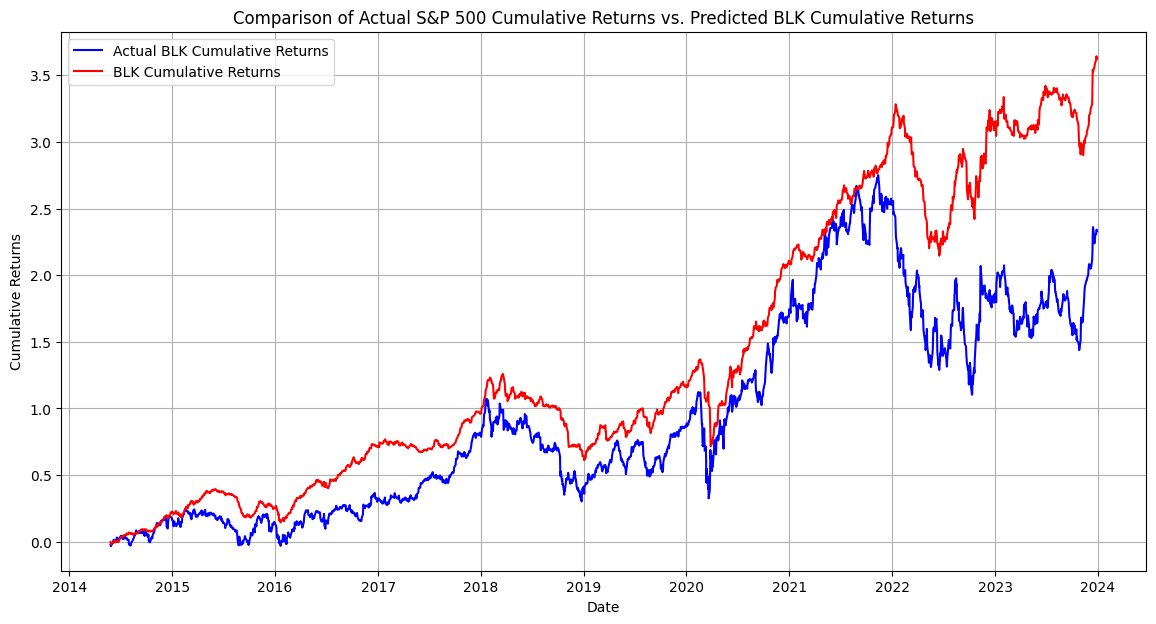

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(results_df['Date'], actual_cumulative_returns, label=f'Actual {user_ticker} Cumulative Returns', color='blue')
plt.plot(results_df['Date'], results_df['predicted_cumulative_returns'], label=f'{user_ticker} Cumulative Returns', color='red')
plt.title(f'Comparison of Actual S&P 500 Cumulative Returns vs. Predicted {user_ticker} Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

## 60/40

In [ ]:
# Define the tickers
spy_ticker = 'SPY'  # S&P 500 ETF
agg_ticker = 'AGG'  # Aggregate Bond ETF
snp_ticker = '^GSPC'

# Fetch historical data
spy_data = yf.download(spy_ticker, start='2014-01-01', end='2024-01-01')
agg_data = yf.download(agg_ticker, start='2014-01-01', end='2040-01-01')
snp_data = yf.download(snp_ticker, start='2014-01-01', end='2040-01-01')

# Calculate daily returns
spy_data['Returns'] = spy_data['Adj Close'].pct_change()
agg_data['Returns'] = agg_data['Adj Close'].pct_change()
snp_data['Returns'] = snp_data['Adj Close'].pct_change()

# Calculate weighted returns for the 60/40 portfolio
portfolio_returns = 0.6 * spy_data['Returns'] + 0.4 * agg_data['Returns']

# Calculate cumulative returns
portfolio_cumulative_returns = (1 + portfolio_returns).cumprod() - 1
snp_cumulative_returns = (1 + snp_data['Returns']).cumprod() - 1


# Prepare for plotting
portfolio_cumulative_returns = portfolio_cumulative_returns.rename("60/40 Portfolio Cumulative Returns")
portfolio_cumulative_returns.index = pd.to_datetime(portfolio_cumulative_returns.index)
snp_cumulative_returns = snp_cumulative_returns.rename("S&P 500 Cumulative Returns")
snp_cumulative_returns.index = pd.to_datetime(snp_cumulative_returns.index)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


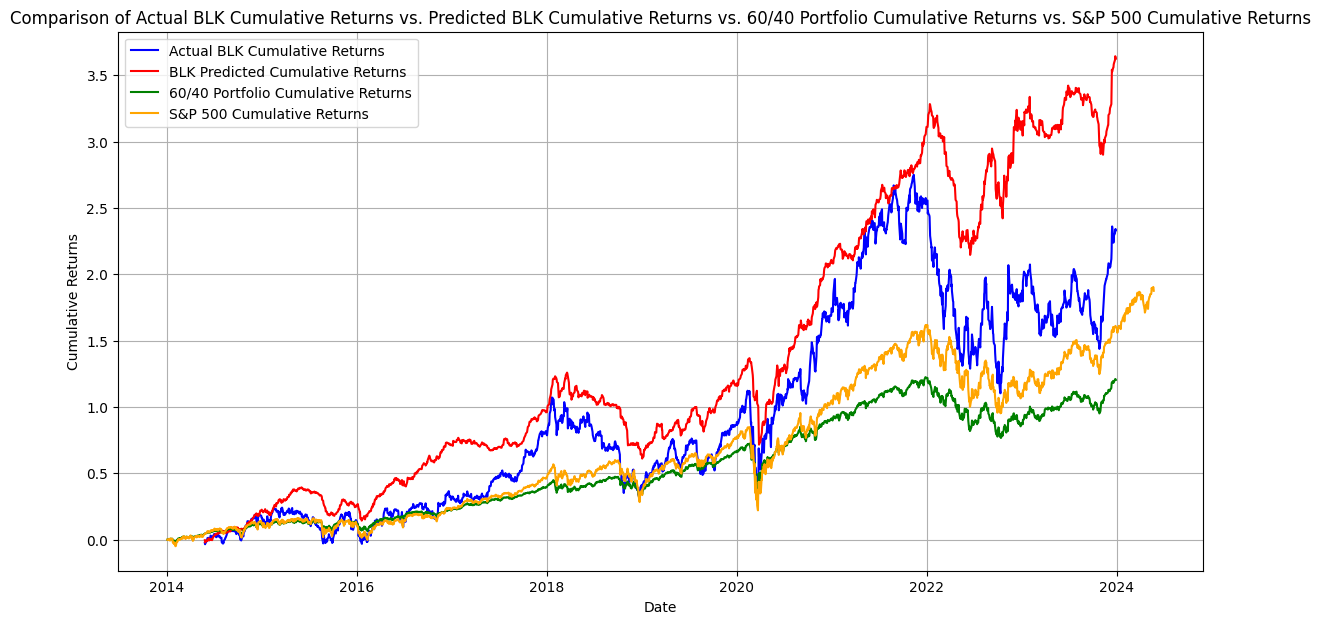

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(results_df['Date'], actual_cumulative_returns, label=f'Actual {user_ticker} Cumulative Returns', color='blue')
plt.plot(results_df['Date'], results_df['predicted_cumulative_returns'], label=f'{user_ticker} Predicted Cumulative Returns', color='red')
plt.plot(portfolio_cumulative_returns, label='60/40 Portfolio Cumulative Returns', color='green')
plt.plot(snp_cumulative_returns, label='S&P 500 Cumulative Returns', color='orange')
plt.title(f'Comparison of Actual {user_ticker} Cumulative Returns vs. Predicted {user_ticker} Cumulative Returns vs. 60/40 Portfolio Cumulative Returns vs. S&P 500 Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Calculate weighted returns for the 60/40 portfolio
portfolio_daily_returns = 0.6 * spy_data['Returns'] + 0.4 * agg_data['Returns']

# Cleaning the data to handle NaN values, which typically appear on the first row
portfolio_daily_returns = portfolio_daily_returns.dropna()

# Convert the index to datetime if not already, useful for time series operations
portfolio_daily_returns.index = pd.to_datetime(portfolio_daily_returns.index)

# Display the first few rows to verify
print(portfolio_daily_returns.head())


Date
2014-01-03    0.000052
2014-01-06   -0.001213
2014-01-07    0.003872
2014-01-08   -0.001069
2014-01-09    0.000956
Name: Returns, dtype: float64


## Backtest Analysis

In [ ]:
def calculate_financial_metrics(portfolio_returns, benchmark_returns, risk_free_rate):
    """Calculate financial metrics for the portfolio using daily data over the last 10 years."""
    # Align portfolio and benchmark returns by dates
    aligned_portfolio_returns, aligned_benchmark_returns = portfolio_returns.align(benchmark_returns, join='inner')

    # Fill any missing values that might result from alignment
    aligned_portfolio_returns.fillna(method='ffill', inplace=True)
    aligned_portfolio_returns.fillna(method='bfill', inplace=True)
    aligned_benchmark_returns.fillna(method='ffill', inplace=True)
    aligned_benchmark_returns.fillna(method='bfill', inplace=True)

    # Calculate daily excess returns for Alpha and other calculations
    daily_rf_rate = risk_free_rate / 252
    excess_returns = aligned_portfolio_returns - daily_rf_rate
    benchmark_excess_returns = aligned_benchmark_returns - daily_rf_rate

    # Alpha Calculation (using CAPM)
    cov_matrix = np.cov(excess_returns, benchmark_excess_returns)
    beta = cov_matrix[0, 1] / cov_matrix[1, 1]
    alpha = (excess_returns.mean() * 252) - (beta * benchmark_excess_returns.mean() * 252)

    # Maximum Drawdown Calculation
    cumulative_returns = (1 + aligned_portfolio_returns).cumprod()
    rolling_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - rolling_max) / rolling_max
    max_drawdown = drawdown.min()

    # Sharpe Ratio Calculation (Annualized)
    annualized_return = (excess_returns.mean() * 252)
    annualized_std_dev = excess_returns.std() * np.sqrt(252)
    sharpe_ratio = (annualized_return - daily_rf_rate) / annualized_std_dev

    return {
        'Alpha': alpha,
        'Beta': beta,
        'Max Drawdown': max_drawdown,
        'Sharpe Ratio': sharpe_ratio,
    }

In [ ]:
print(results_df.shape)
print(results_df.head())

(2004, 4)
        Date  Predictions  Max_Importance_Indices  \
0 2014-05-27    -0.003554                       6   
1 2014-05-28    -0.017299                       6   
2 2014-05-29     0.005530                       6   
3 2014-05-30     0.001285                       6   
4 2014-06-03     0.004558                       6   

   predicted_cumulative_returns  
0                     -0.003554  
1                     -0.020792  
2                     -0.015377  
3                     -0.014111  
4                     -0.009617  


In [ ]:
#final_combined_data = final_combined_data.iloc[100:]
print(final_combined_data.shape)  # Check the new number of rows and columns
print(final_combined_data.head())  # Display the first few rows to confirm the first 100 are gone


(2605, 21)
            Sentiment Index  PUT_CALL_VOLUME_RATIO_CUR_DAY  BEST_PE_RATIO  \
Date                                                                        
2014-01-06             81.2                         1.3972        16.5829   
2014-01-07             81.2                         2.0340        16.6853   
2014-01-08             81.2                         1.7187        16.6867   
2014-01-09             81.2                         1.6091        16.6959   
2014-01-10             81.2                         1.4204        16.7383   

                 BLK  ICE U.S. Dollar Index  Euro-USD Exchange Rate  \
Date                                                                  
2014-01-06 -0.000319              -0.001733               -0.005167   
2014-01-07  0.009202               0.002232                0.002645   
2014-01-08 -0.000316               0.002598               -0.001144   
2014-01-09 -0.002461              -0.000370               -0.003257   
2014-01-10 -0.003607   

In [ ]:
# Extract the returns
portfolio_returns = results_df['Predictions']
benchmark_returns = final_combined_data1[user_ticker]

# Calculate the financial metrics for the predicted returns
metrics_predicted = calculate_financial_metrics(portfolio_returns, benchmark_returns, risk_free_rate)

In [ ]:
portfolio_returns = snp_data['Returns']
benchmark_returns = snp_data['Returns']

# Calculate the financial metrics for the predicted returns
metrics_actual = calculate_financial_metrics(portfolio_returns, benchmark_returns, risk_free_rate)

In [ ]:
# Fetch historical data for user_ticker and benchmark
user_ticker_data = yf.download(user_ticker, start='2014-01-01', end='2024-01-01')

# Calculate daily returns
user_ticker_data['Returns'] = user_ticker_data['Adj Close'].pct_change()

# Drop any rows with NaN values which might have been generated by pct_change()
user_ticker_data.dropna(subset=['Returns'], inplace=True)

# Calculate the financial metrics for the user_ticker
metrics = calculate_financial_metrics(user_ticker_data['Returns'], snp_data['Returns'], risk_free_rate)



[*********************100%%**********************]  1 of 1 completed


In [ ]:
portfolio_returns_df = portfolio_daily_returns.to_frame(name='Daily Returns')
print(portfolio_returns_df.head())

            Daily Returns
Date                     
2014-01-03       0.000052
2014-01-06      -0.001213
2014-01-07       0.003872
2014-01-08      -0.001069
2014-01-09       0.000956


In [ ]:
portfolio_returns = portfolio_returns_df['Daily Returns']
benchmark_returns = snp_data['Returns']

# Calculate the financial metrics for the predicted returns
metrics_bm = calculate_financial_metrics(portfolio_returns, benchmark_returns, risk_free_rate)

In [ ]:
print(f"Predicted 100% {user_ticker} Portfolio Metrics:", metrics_predicted)
print(f"Actual 100% {user_ticker} Portfolio Metrics:", metrics)
print("100% S&P Portfolio Metrics:", metrics_actual)
print("60/40 Portfolio Metrics:", metrics_bm)

Predicted 100% BLK Portfolio Metrics: {'Alpha': 0.1883206332904426, 'Beta': -0.00033293324973444725, 'Max Drawdown': -0.2867504966676964, 'Sharpe Ratio': 1.4555521702232026}
Actual 100% BLK Portfolio Metrics: {'Alpha': 0.02133501805412459, 'Beta': 1.2557344797564165, 'Max Drawdown': -0.4390170367766011, 'Sharpe Ratio': 0.5326123448506745}
100% S&P Portfolio Metrics: {'Alpha': 0.0, 'Beta': 1.0, 'Max Drawdown': -0.339249600026533, 'Sharpe Ratio': 0.5951844324251704}
60/40 Portfolio Metrics: {'Alpha': 0.012951912135374888, 'Beta': 0.6002565599672507, 'Max Drawdown': -0.21716992743777722, 'Sharpe Ratio': 0.6656418290371332}
